# OpenPose Keypoint Analysis of a Single Pitch from Multiple Angles

### By: Jake Bell

## Setup:

Make sure that you have followed the instuctions correctly on how to generate the .JSON output folders through openpose, as well as the correct way to organize them so that this program can access them.

This program works best on videos from one angle, of the same subject, performing a similar motion, such as pitching.

## How to Run the Program:
When prompted, fill out the appropriate information for each video file.
The needed variables are:
- json_folder_name 
    * The name of the folder containing all the video output folders
- subject_height
    * The measurement of how tall the subject is, in meters
- camera_pixel_width
    * The measurement of how many pixels wide the video is
- camera_pixel_height
    * The measurement of how many pixels tall the video is
- camera_fps
    * The measurement of how many frames per second the video was filmed at
- is_right_handed
    * This variable specifies which arm is the subject's throwing arm, answer only "True" or "False"




# The Program:

## General Prep for Calculations

### Imports

In [18]:
import os
import re 
import pandas as pd
import io
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

###  Calculation Variables

In [2]:

#take in variable names through user input, typecast to change input from string to floats
json_folder_name = input("Enter the name of the folder containing the all of the .json files: (ex: folder_for_json_keypoints)\n") # + "\\"

subject_height = float( input("Enter how tall the subject is is in meters: (ex: 1.5)\n") )

camera_pixel_width = float( input("Enter the camera pixel width: (ex: 1280)\n") )

camera_pixel_height = float( input("Enter the camera pixel height: (ex: 1024)\n") )

camera_fps = float( input("Enter the frames per second that the video was captured in: (ex: 30)\n") )

is_right_handed = input( 'Enter "True" if the pitcher is right-handed, or "False" if the subject is left-handed\n') 


Enter the name of the folder containing the all of the .json files: (ex: folder_for_json_keypoints)
folder_for_json_keypoints
Enter how tall the subject is is in meters: (ex: 1.5)
1.5
Enter the camera pixel width: (ex: 1280)
1280
Enter the camera pixel height: (ex: 1024)
1024
Enter the frames per second that the video was captured in: (ex: 30)
240
Enter "True" if the pitcher is right-handed, or "False" if the subject is left-handed
False


### Define Functions

In [3]:

#Distance function: gets the distance in Meters between 2 points, given x1 y1 x2 y2 (in pixels) and conversion ratio
def calculate_distance( x1, y1, x2, y2, conversion_ratio):
    #distance formula (in pixels)
    distance_traveled_pixels = math.sqrt( ((x2 - x1)**2) + ((y2 - y1)**2) )

    #convert distance traveled in pixels to distance traveled in meters
    distance_traveled_meters = distance_traveled_pixels * conversion_ratio 
    #print('distance traveled: ', distance_traveled_meters, 'meters')
    
    return distance_traveled_meters

#Velocity function: gets the velocity of a point, given the distance traveled and camera_fps
def calculate_velocity( distance_traveled, camera_fps):
    velocity = distance_traveled * camera_fps #velocity = distance/time
    #print('velocity (m\s): ', velocity)
    
    return velocity

#Acceleraion function: gets the aceleration given velocity at 2 consecutive frames and camera_fps
def calculate_acceleration(v1, v2, camera_fps):
    
    acceleration = (v2 - v1)/(1/camera_fps)
    #print( 'acceleration (m/s^2)', acceleration)
    
    return acceleration


## Set up Dataframe storage



Instantaite the main dictionary, which is where we will store ALL of the dataframes.

It is a 2D dictionary, containing 4 separate dictionaries inside of it (position, velocity, acceleration, throwing_arm).

Each of the 4 inside dictionaries will contain 1 dataframe for every video that was inputted.

In [4]:
#MAIN DICTIONARY INSTANTIATION
main_dict = {
    'pos': {},
    'velocity' : {},
    'acceleration' : {},
    'ta' : {} 
}

As we generate the dataframes from the raw data, we will add them to their corresponding location in the 2D dictionary.

## Read .JSON data into Dataframes

In [5]:
#current directory files, what we can access
current_files = os.listdir()
print('current files', current_files, '\n' )


#change directory to the folder with all of the video outputs
json_folder_name = "folder_for_json_keypoints\\"  # \\ is needed to count as '\'
os.chdir( json_folder_name )

#get a list of all the files in the video output folder
json_folders = os.listdir()
print('json keypoint folders', json_folders, '\n\n' )


#use the list of all the video output folders (json_files) to go through each one to get their data
for folder in json_folders:
    
    #show where it is working
    print("Currently working with", folder, '\n')
    os.chdir( folder)
    
    #obtain the list of the .json output files for the specified folder
    files = os.listdir()
    
    #shows the first few file names for testing
    #print(files[0:3], '\n')
    
    
    #this line is to set up the string that will be used to create a dataframe
    data_string = ('x0,y0,c0,x1,y1,c1,x2,y2,c2,x3,y3,c3,x4,y4,c4,x5,y5,c5,'
    'x6,y6,c6,x7,y7,c7,x8,y8,c8,x9,y9,c9,x10,y10,c10,'
    'x11,y11,c11,x12,y12,c12,x13,y13,c13,x14,y14,c14,x15,y15,c15,'
    'x16,y16,c16,x17,y17,c17,x18,y18,c18,x19,y19,c19,'
    'x20,y20,c20,x21,y21,c21,x22,y22,c22,x23,y23,c23,x24,y24,c24\n')
    
    #goes through every .JSON file, reformats it to get the data, and adds it to the data_string
    for file in files:

        current_file = open( file, 'r') #open up the file for reading
        line = current_file.readline() #read the first line of the file (which contains all of its data)
        #print(line) #testing command

        #REGULAR EXPRESSIONS TIME
        #step 1
        reg_expression_string = '\"pose_keypoints_2d\"\:\[[0-9\,\.]+\]'
        result = re.search( reg_expression_string, line) #pulls out section that we want
        line = result.group(0) #pulls out the correct part from our result

        #step 2
        reg_expression_string = '[0-9,.]{2,}'
        result_2 = re.search(  reg_expression_string, line) #select only the data, not the headers
        line = result_2.group(0) #pull out the correct part from the result

        line += '\n' #needed to show that the entry is over
        data_string += line #add the line to our data_string 

        #close file reading to move on to the next file
        current_file.close() 
    
    #turn the data_string into a dataframe
    data_string = io.StringIO( data_string)
    
    #craft the right name for the dataframe
    print( folder)
    df_name = folder + '_pos_df'
    print( df_name,'\n')
    
    main_dict['pos'][df_name] = pd.read_csv( data_string, sep=",")
    
    #pos_df = pd.read_csv( data_string, sep=",") #position_dataframe
    #pos_df.head(5) 

    os.chdir('..')
    
#go back to original directory once all outpt data has been obtained
os.chdir('..')
print("\nback to the starting folder", os.getcwd(), '\n' )

current files ['.ipynb_checkpoints', 'folder_for_json_keypoints', 'openpose_example_video_2_30fps_json_keypoints', 'openpose_keypoint_analysis_multi_video.ipynb', 'Outdated program versions'] 

json keypoint folders ['cam1_throw1_json_keypoints', 'cam2_throw1_json_keypoints', 'cam3_throw1_json_keypoints'] 


Currently working with cam1_throw1_json_keypoints 

cam1_throw1_json_keypoints
cam1_throw1_json_keypoints_pos_df 

Currently working with cam2_throw1_json_keypoints 

cam2_throw1_json_keypoints
cam2_throw1_json_keypoints_pos_df 

Currently working with cam3_throw1_json_keypoints 

cam3_throw1_json_keypoints
cam3_throw1_json_keypoints_pos_df 


back to the starting folder C:\Users\jakeb\OneDrive\Documents\jake work\Summer Research 2020\OpenPose Python programs 



**Example of how to access certain dataframes within the 2D dictionary**

In [6]:
pos_df_names_list= list( main_dict['pos'].keys() ) 
print( 'here is the dataframe', pos_df_names_list[0])
main_dict['pos'][pos_df_names_list[0]].head(5)

here is the dataframe cam2_throw1_json_keypoints_pos_df


,x0,y0,c0,x1,y1,c1,x2,y2,c2,x3,...,c21,x22,y22,c22,x23,y23,c23,x24,y24,c24
0,701.523,184.714,0.922055,679.088,246.284,0.761764,670.757,248.970,0.807569,684.646,...,0.575187,824.329,539.474,0.803155,810.305,542.291,0.832383,746.221,508.734,0.829294
1,701.527,184.698,0.919285,679.190,249.017,0.798557,670.713,246.277,0.807881,684.722,...,0.554676,824.335,542.145,0.808762,810.314,544.934,0.839504,746.223,511.511,0.806956
2,701.538,184.699,0.920592,679.209,251.711,0.800283,670.758,248.987,0.811336,684.734,...,0.533347,824.296,542.279,0.837413,810.277,545.012,0.855012,746.224,511.526,0.813389
3,701.544,184.709,0.923041,681.804,251.743,0.813837,673.442,249.026,0.818044,687.434,...,0.578544,821.587,544.924,0.839328,807.555,545.069,0.840558,748.807,511.538,0.813916
4,701.545,184.731,0.926861,681.926,251.845,0.837003,673.433,246.285,0.818961,687.471,...,0.545305,818.830,544.953,0.852909,804.790,545.062,0.827941,748.810,511.544,0.800242


### Calculate Conversion Ratio
Calculate the conversion between pixels and meters, using the subject hight and video pixel dimensions

In [7]:

#choose which dataframe to get the ratio from
pos_df_names_list= list( main_dict['pos'].keys() ) 
calculation_df = main_dict['pos'][pos_df_names_list[0]]

#Calculate the conversion ratio by using the json dataframes


#figure out how tall the subject is from feet to eye level in meters
subject_height = float(subject_height) - 0.127

#if right handed, right leg will be planted, so we use that point for measurement
if( is_right_handed == 'True'):
    eye_level = [ calculation_df.loc[0, 'x0'], calculation_df.loc[0, 'y0'] ]
    foot_level = [ calculation_df.loc[0, 'x24'], calculation_df.loc[0, 'y24'] ]
#if left handed, left leg will be planted, so we use that point for measurement
elif( is_right_handed == 'False'):
    eye_level = [ calculation_df.loc[0, 'x0'], calculation_df.loc[0, 'y0'] ]
    foot_level = [ calculation_df.loc[0, 'x21'], calculation_df.loc[0, 'y21'] ]

#figure out the distance in pixels, using distance function
pixel_height = calculate_distance( eye_level[0], eye_level[1], foot_level[0], foot_level[1], 1)

#use height in meters to height in pixels to calculate the ratio
conversion_ratio_meter_per_pixel = subject_height / pixel_height

print('\nConversion ratio: 1 pixel =', conversion_ratio_meter_per_pixel, 'meters' )



Conversion ratio: 1 pixel = 0.002420637463985842 meters


## Velocity Calculations

Nested for loops go through each respective position dataframe and calculate velocity for each keypoint by using a frame and the one before it

In [84]:

#cycle through the position dataframes
for pos_df in pos_df_names_list:
    
    print( 'position dataframe:', pos_df)
    
    #create dictionary to store velocity values, then later turn into a dataframe
    velocity_dict ={}

    #cycles through dataframe columns
    for i in range( 0, int( main_dict['pos'][pos_df].shape[1]/3 ) ): #for loop that goes through all of the columns

        #print('i is: ', i) #to show where loop is

        #gets the correct column names to be referenced
        x_col = 'x'+str(i) #x0,x1,x2....
        y_col = 'y'+str(i) #y0,y1,y2...
        #print(x_col, y_col) #to show the column names

        #now use column names to get correct data for the formula

        #list to hold velocity values
        temp_list = [0] #first frame will have a velocity of 0

        #cycles through dataframe rows
        for j in range( 1, main_dict['pos'][pos_df].shape[0] ):

            #gets the 2 points to be used
            x1 = main_dict['pos'][pos_df].loc[ j-1, x_col]
            y1 = main_dict['pos'][pos_df].loc[ j-1, y_col]

            x2 = main_dict['pos'][pos_df].loc[ j, x_col]
            y2 = main_dict['pos'][pos_df].loc[ j, y_col]

            #call distance function
            distance_traveled_pixels = calculate_distance( x1, y1, x2, y2, conversion_ratio_meter_per_pixel)

            #call velocity function
            velocity = calculate_velocity( distance_traveled_pixels, camera_fps)
            
            if( velocity > 200): #get rid of outliers
                velocity = 'NaN'
            
            #print('distance', distance_traveled_pixels, 'velocity', velocity)

            #append velocity to the end of "temp_list"
            temp_list.append( velocity )

        #now that the column is exhausted, add temp_list to the dictionary
        velocity_col = 'v' + str(i)
        velocity_dict[ velocity_col ] = temp_list
        #print( velocity_dict[ velocity_col ])
        
    #turn the dictionary containing velocity values, into a DataFrame
    velocity_df = pd.DataFrame( velocity_dict)
    
    #reorder the columns to be numeric
    velocity_df = velocity_df[[ 'v0', 'v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v16','v17','v18','v19','v20','v21','v22','v23','v24']]

    #craft the right name for the dataframe
    df_name = pos_df[:-6] + 'velocity_df'
    print( 'generated velocity dataframe:', df_name,'\n')
    
    #put the generated velocity dataframe in its correct spot in the main dictionary
    main_dict['velocity'][df_name] = velocity_df
    


position dataframe: cam2_throw1_json_keypoints_pos_df
generated velocity dataframe: cam2_throw1_json_keypoints_velocity_df 

position dataframe: cam3_throw1_json_keypoints_pos_df
generated velocity dataframe: cam3_throw1_json_keypoints_velocity_df 

position dataframe: cam1_throw1_json_keypoints_pos_df
generated velocity dataframe: cam1_throw1_json_keypoints_velocity_df 



Check the results to ensure velocity dataframes were calculated correctly

In [85]:
velocity_df_names_list= list( main_dict['velocity'].keys() ) 
print( 'here is the dataframe', velocity_df_names_list[0])
main_dict['velocity'][velocity_df_names_list[0]].head(5)

here is the dataframe cam3_throw1_json_keypoints_velocity_df


,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24
0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0.000000,0.000000,...,0,0,0,0.000000,0,0,0,0,0,0
1,1.57729,0.018968,0.020066,0.0186268,1.60797,0.005196,0.005839,2.25327,2.193817,0.032084,...,1.57672,1.4919,0,1.502420,3.61422,3.17377,3.20813,1.57502,0.0556382,0.050446
2,0.0112201,0.043463,0.058281,0.018463,2.23097,0.017821,0.047514,0.0461922,1.583445,0.058619,...,1.55231,0.00831798,0,0.003720,1.58603,0.0369259,0.0106014,1.58776,1.57346,1.58262
3,0.0288962,0.025680,1.548091,1.5436,0.0226572,0.011099,1.562764,1.55706,0.034178,1.519011,...,1.57903,1.56988,0,0.023151,1.60635,0.0497487,1.61359,1.62126,0.0956899,0.0754524
4,0.0147086,1.557011,0.033012,0.0119767,1.5587,1.580773,1.498924,0.0142422,3.178411,2.235397,...,0.0256213,1.54887,0,2.136965,1.59709,1.60002,1.62404,2.25802,0.0653798,0.00938558


## Acceleration Calculations

Nested for loops go through the velocity dataframes and calculate acceleration by measuring how the velocity changes from frame to frame.

In [86]:
#get a list of all the names for the velocity dataframe
velocity_df_names_list =  list( main_dict['velocity'].keys() )

'''
Note:
    due to the row 0 being velocity 0, velocity of row 1 will be crazy.
    Solution to issue is to either ignore first 2 frames, or approx. what frame 1 is.
    We will choose to ignore first 2 frames for acceleration

'''

#cycle through the video output dataframes
for velocity_df in velocity_df_names_list:
    
    print( 'velocity dataframe:', velocity_df)
    
    #create dictionary to store velocity values, then later turn into a dataframe
    acceleration_dict ={}

    #cycles through dataframe columns
    for i in range( 0, int( main_dict['velocity'][velocity_df].shape[1] ) ): #for loop that goes through all of the columns

        #print('i is: ', i) #to show where loop is
        
        #gets the correct column name to be referenced
        v_col = 'v'+ str(i)
        #print( v_col)
        
        #list to hold acceleration values
        temp_list = [0] #first frame will have a acceleration of 0
          
            
        #cycles through dataframe rows
        for j in range( 1, main_dict['velocity'][velocity_df].shape[0] ):

            #gets the 2 points to be used
            v1 = main_dict['velocity'][velocity_df].loc[ j-1, v_col]
            v2 = main_dict['velocity'][velocity_df].loc[ j, v_col]
            #print(v2) 
            
            #call acceleration function, but make sure not using 'NaN' values
            if( v1 == 'NaN' or v2 == 'NaN'):
                acceleration = 'NaN'
            else:
                acceleration = calculate_acceleration( v1, v2, camera_fps)
            #print( acceleration)
            
            #append acceleration to the end of "temp_list"
            temp_list.append( acceleration)

        #now that the column is exhausted, add temp_list to the acceleration dictionary
        acceleration_col = 'a' + str(i)
        acceleration_dict[ acceleration_col ] = temp_list
        #print( acceleration_dict[ acceleration_col ])
        
    #turn the dictionary containing acceleration values into a DataFrame
    acceleration_df = pd.DataFrame( acceleration_dict)

    #reorder the columns of the dataframe
    acceleration_df = acceleration_df[[ 'a0','a1','a2','a3','a4','a5','a6','a7','a8','a9','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19','a20','a21','a22','a23','a24']]

    #craft the right name for the dataframe
    df_name = velocity_df[:-11] + 'acceleration_df'
    print( 'generated acceleration dataframe:', df_name,'\n')
    
    #put the generated acceleration dataframe in its correct spot in the main dictionary
    main_dict['acceleration'][df_name] = acceleration_df

velocity dataframe: cam3_throw1_json_keypoints_velocity_df
generated acceleration dataframe: cam3_throw1_json_keypoints_acceleration_df 

velocity dataframe: cam1_throw1_json_keypoints_velocity_df
generated acceleration dataframe: cam1_throw1_json_keypoints_acceleration_df 

velocity dataframe: cam2_throw1_json_keypoints_velocity_df
generated acceleration dataframe: cam2_throw1_json_keypoints_acceleration_df 



Check the results to ensure acceleration dataframes were calculated correctly

In [87]:
acceleration_df_names_list= list( main_dict['acceleration'].keys() ) 
print( 'here is the dataframe', acceleration_df_names_list[0])
main_dict['acceleration'][acceleration_df_names_list[0]].head(5)

here is the dataframe cam2_throw1_json_keypoints_acceleration_df


,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24
0,0.000000,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,...,0.000000,0,0,0,0,0,0,0,0,0
1,2.299517,381.323983,375.531652,12.4592,382.006,866.45,536.933,8.67825,375.503308,374.093902,...,358.752801,1.94202,1.14976,3.17946,864.182,549.027,16.1069,372.415,368.512,387.194
2,-0.759477,-5.693675,2.372263,-10.6466,-2.06078,-491.645,-153.225,-3.1273,-368.948675,-368.170232,...,0.139996,0.0542981,3.34019,2.53881,-92.7184,-161.245,361.911,-352.956,-356.475,-385.098
3,0.085964,-13.785276,-3.637731,535.233,-378.075,16.1952,-370.101,12.3155,-0.838055,-1.851492,...,-357.887362,0.750112,-2.43131,0.499993,-392.495,2.30223,382.798,508.435,367.571,358.052
4,1.444595,-339.672796,7.909993,-160.97,382.985,478.732,-6.9933,352.067,-3.145639,529.528830,...,1.433572,2.10962,0.747308,363.136,787.773,473.401,-215.996,-143.468,5.91347,-359.213


## Throwing Arm Dataframe setup

Set up the throwing arm dataframe with the keypoints numbered 2, 3, and 4 (or 5, 6, 7 if left handed)

In [88]:
#get a list of all the names for the acceleration dataframe
json_folders = os.listdir(json_folder_name)

#used to check for good input for is_right_handed
good_input = 1    
    
for folder in json_folders:
    #print( folder)
    
    if( is_right_handed == 'True'):
        ta_position_df = main_dict['pos'][folder + '_pos_df'].filter( items = ['x2','y2','x3','y3','x4','y4'])
        ta_velocity_df = main_dict['velocity'][folder + '_velocity_df'].filter( items = ['v2','v3','v4'])
        ta_acceleration_df = main_dict['acceleration'][folder + '_acceleration_df'].filter( items = ['a2','a3','a4'])
        #print('RH pitcher') 
    elif( is_right_handed == 'False'):
        ta_position_df = main_dict['pos'][folder + '_pos_df'].filter( items = ['x5','y5','x6','y6','x7','y7'])
        ta_velocity_df = main_dict['velocity'][folder + '_velocity_df'].filter( items = ['v5','v6','v7'])
        ta_acceleration_df = main_dict['acceleration'][folder + '_acceleration_df'].filter( items = ['a5','a6','a7'])
        #print( 'LH pitcher')
    else:
        print( 'You did not input "is_right_handed" correctly, please go back to earlier section and input "True" or "False"')
        good_input = 0

    #combines the 3 dataframes to form the throwing arm dataframe
    ta_df = pd.concat( [ta_position_df, ta_velocity_df, ta_acceleration_df], axis=1 )
    

    #reorder the rows in a more logical way
    if( is_right_handed == 'True ' and good_input == 1):
        ta_df = ta_df[['x2','y2','v2','a2','x3','y3','v3','a3','x4','y4','v4','a4']]
    elif( is_right_handed == 'True ' and good_input == 1):
        ta_df = ta_df[['x5','y5','v5','a5','x6','y6','v6','a6','x7','y7','v7','a7']] 

    
    
    #add the throwing arm dataframe to the dictionary 
    
    #craft the right name for the dataframe
    df_name = folder + '_ta_df'
    print( 'generated throwing arm dataframe:', df_name,'\n')
    
    #put the generated acceleration dataframe in its correct spot in the main dictionary
    main_dict['ta'][df_name] = ta_df
    

generated throwing arm dataframe: cam1_throw1_json_keypoints_ta_df 

generated throwing arm dataframe: cam2_throw1_json_keypoints_ta_df 

generated throwing arm dataframe: cam3_throw1_json_keypoints_ta_df 



## Throwing arm angle Calculation

We have our dataframes for the subject's throwing arm, but we want to add a column displaying the arm's angle as the video progresses.

Using for loops, we go through each throwing arm dataframe, and calculate the angle between the 3 points.

In [89]:
#get a list of all the names for the throwing arm dataframe
ta_df_names_list= list( main_dict['ta'].keys() )   
    

#loop through each throwing arm dataframe, calculate the angle, and add a column showing the angle
for ta_df_name in ta_df_names_list:
    
    print( 'throwing arm dataframe:', ta_df_name)
    
    #use throwing arm dataframe name to make a shortcut for the current dataframe
    ta_df = main_dict['ta'][ta_df_name]
    
    #instantiate list to hold the angles for each consecutive frame
    angle_list = []
    
    #loop through each row, get the data, and make the calculation
    for i in range( 0, int( ta_df.shape[0] )):
        #print(i)
                   
        if( is_right_handed == 'True'): #if right handed pitcher
            shoulder = [ ta_df.loc[ i, 'x2'], ta_df.loc[ i, 'y2'] ]  
            elbow =  [ ta_df.loc[ i, 'x3'], ta_df.loc[ i, 'y3'] ]
            wrist = [ ta_df.loc[ i, 'x4'], ta_df.loc[ i, 'y4'] ]
                   
        else: #if left handed pitcher
            shoulder = [ ta_df.loc[ i, 'x5'], ta_df.loc[ i, 'y5'] ]  
            elbow =  [ ta_df.loc[ i, 'x6'], ta_df.loc[ i, 'y6'] ]
            wrist = [ ta_df.loc[ i, 'x7'], ta_df.loc[ i, 'y7'] ]
            
        
        #this is to handle if the keypoint was not recognised at a certain point in the frame
        if( p12==0 or p13==0 or p23==0):
            angle = 'NaN'
        else:
            #angle calculation formula from internet, point b is where we want the angle
            angle = math.degrees(math.atan2(wrist[1]-elbow[1], wrist[0]-elbow[0]) - math.atan2(shoulder[1]-elbow[1], shoulder[0]-elbow[0]))
            angle = abs( angle) if angle < 0 else angle
 
        
        #print( angle )

        #add angle to the angle_list
        angle_list.append( angle)

    #add angle_list to the throwing arm dataframe
    
    #if throwing arm elbow angle already exists in dataframe, delete the column and replace it
    if( 'TA_elbow_angle' in ta_df ):
        print('angle calculation already exists in dataframe, deleting and replacing previous throwing arm column column\n')
        ta_df.pop('TA_elbow_angle')
        
        
    main_dict['ta'][ta_df_name].insert( 0,'TA_elbow_angle', angle_list)

    
    

throwing arm dataframe: cam1_throw1_json_keypoints_ta_df
throwing arm dataframe: cam3_throw1_json_keypoints_ta_df
throwing arm dataframe: cam2_throw1_json_keypoints_ta_df


Now we have the final elbow angle calculations, here is one of the Throwing Arm dataframes

In [90]:
ta_df_names_list= list( main_dict['ta'].keys() ) 
print( 'here is the dataframe', ta_df_names_list[0])
main_dict['ta'][ta_df_names_list[0]].head(5)

here is the dataframe cam1_throw1_json_keypoints_ta_df


,TA_elbow_angle,x5,y5,x6,y6,x7,y7,v5,v6,v7,a5,a6,a7
0,38.984484,1611.29,205.927,1646.54,314.162,1600.55,284.323,0.000000,0.000000,0,0.000000,0.000000,0
1,37.411555,1611.32,205.955,1646.49,314.128,1603.21,284.296,0.023840,0.035127,1.54541,5.721676,8.430539,370.899
2,37.405175,1611.30,205.950,1646.51,314.125,1603.22,284.300,0.011977,0.011749,0.00625706,-2.847280,-5.610767,-369.398
3,37.441580,1611.30,205.908,1646.54,314.117,1603.22,284.322,0.024400,0.018038,0.012781,2.981609,1.509260,1.56574
4,40.095480,1611.31,205.941,1649.13,314.120,1603.28,286.967,0.020032,1.504669,1.53702,-1.048242,356.791590,365.816


## Graphics

Now that we have done all of the necessary calculations, we can begin to graph our results in meaningful ways 

**Here is a graph of how the Throwing Arm angle calculation differs between each video**

Throwing Arm Elbow Angle for every video:
 x axis is frame number, y axis is the throwing arm angle


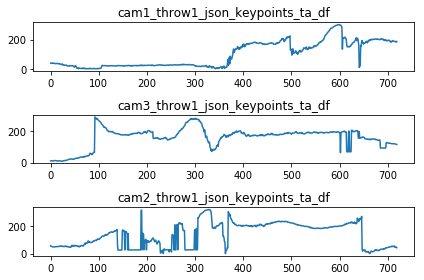

In [91]:
#scaled stacked axes graphics
ta_df_names_list= list( main_dict['ta'].keys() ) 
#print( ta_df_names_list)

#figure out how many subplots to make, as well as what the axes names should be
num_of_ta_dfs = len( ta_df_names_list )
#print( num_of_ta_dfs)

#set up the axes names
axes_list = []
for i in range(0, num_of_ta_dfs):
    axes_list.append('ax' + str(i) )
    #print( axes_list[i])

fig, (axes_list) = plt.subplots( num_of_ta_dfs )
print('Throwing Arm Elbow Angle for every video:\n x axis is frame number, y axis is the throwing arm angle')

    
#go through each dataframe, and plot the TA_elbow_angle on its own subplot
for i in range( 0, num_of_ta_dfs):
    
    data_frame = main_dict['ta'][ta_df_names_list[i]]
    
    x = range( 0, data_frame.shape[0] )
    y = data_frame['TA_elbow_angle']
    
    axes_list[i].plot( x, y)
    axes_list[i].set_title( ta_df_names_list[i])

fig.tight_layout()


**Here is a graph on how velocity of the throwing arm's wrist changes over the course of the video**

Throwing Arm wrist velocity and acceleration for every video:
 x axis is frame number, y axis is velocity


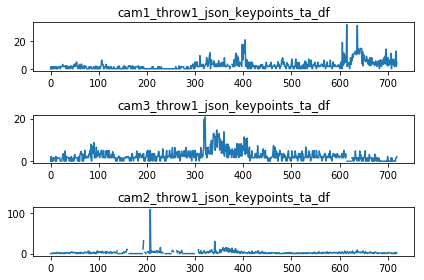

In [92]:
#scaled stacked axes graphics
ta_df_names_list= list( main_dict['ta'].keys() ) 
#print( ta_df_names_list)

#figure out how many subplots to make, as well as what the axes names should be
num_of_ta_dfs = len( ta_df_names_list )
#print( num_of_ta_dfs)

#set up the axes names
axes_list = []
for i in range(0, num_of_ta_dfs):
    axes_list.append('ax' + str(i) )
    #print( axes_list[i])

fig, (axes_list) = plt.subplots( num_of_ta_dfs )
print('Throwing Arm wrist velocity and acceleration for every video:\n x axis is frame number, y axis is velocity')

    
#go through each dataframe, and plot the velocity on its own subplot
for i in range( 0, num_of_ta_dfs):
    
    data_frame = main_dict['ta'][ta_df_names_list[i]]
    
    x = range( 0, data_frame.shape[0] )
    if( is_right_handed == 'True'):
        vel = data_frame['v4']
        acc = data_frame['a4']
    else:
        vel = data_frame['v7']
        acc = data_frame['a7']
        
    axes_list[i].plot( x, vel)
    axes_list[i].set_title( ta_df_names_list[i])

fig.tight_layout()


**Here is a graph on how acceleratio of the throwing arm's wrist changes over the course of the video**

Throwing Arm wrist acceleration for every video:
 x axis is frame number, y axis is acceleration


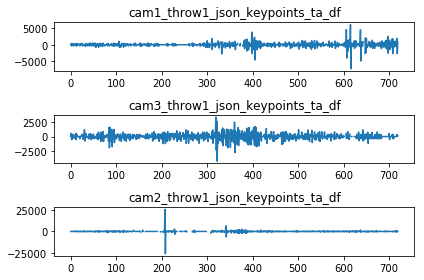

In [93]:
#scaled stacked axes graphics
ta_df_names_list= list( main_dict['ta'].keys() ) 
#print( ta_df_names_list)

#figure out how many subplots to make, as well as what the axes names should be
num_of_ta_dfs = len( ta_df_names_list )
#print( num_of_ta_dfs)

#set up the axes names
axes_list = []
for i in range(0, num_of_ta_dfs):
    axes_list.append('ax' + str(i) )
    #print( axes_list[i])

fig, (axes_list) = plt.subplots( num_of_ta_dfs )
print('Throwing Arm wrist acceleration for every video:\n x axis is frame number, y axis is acceleration')

    
#go through each dataframe, and plot the velocity on its own subplot
for i in range( 0, num_of_ta_dfs):
    
    data_frame = main_dict['ta'][ta_df_names_list[i]]
    
    x = range( 0, data_frame.shape[0] )
    if( is_right_handed == 'True'):
        acc = data_frame['a4']
    else:
        acc = data_frame['a7']
        
    axes_list[i].plot( x, acc)
    axes_list[i].set_title( ta_df_names_list[i])

fig.tight_layout()
